In [1]:
import re
import os, glob
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

import psignifit as ps


In [2]:
data_path = 'selected/'

In [3]:
summary_a20 = pd.read_csv(os.path.join(data_path, "summary_a20.csv"))
summary_a45 = pd.read_csv(os.path.join(data_path, "summary_a45.csv"))
data_files  = glob.glob(os.path.join(data_path, 'a*'))

In [4]:
def extract_name_pattern(file_path):
    'from file path it returns info about an angle and subject id'
    file_name = file_path.split('/')[-1]
    rx = re.compile('a([0-9][0-9])_([0-9]+)\.')
    angle, subj_id = rx.findall(file_name)[0]
    return (int(angle), int(subj_id))

def extract_data_from_part2(dfp2, column_name, condition_tuple):
    '''
    IN:
      *dfp2* data frame from Part 2 of 2d RDK
      column_name
      *condition_tuple* is coherencies you want to extract
    OUT:
      vector with extracted data
    '''
    assert 'cohfix' in dfp2.columns, 'dfp2 lacks cohfix column'
    return dfp2[dfp2.cohfix.map(lambda x: list(x) == sorted(condition_tuple))][column_name].to_numpy()*1.

def compute_mean_sterr_from_vector(vect):
    'returns tuple with mean and sterr from *vect*'
    return np.mean(vect), np.std(vect)/np.sqrt(len(vect))

def get_avg_conditions_part2(dfp2, delta, stair_coh1, stair_coh2, column = 'correct'):
    'Extracts average summaries from all coditions from dfp2 matrix'
    v_ = extract_data_from_part2(dfp2, column, [delta, stair_coh1])
    cong_m, cong_s = compute_mean_sterr_from_vector(v_)
    v_ = extract_data_from_part2(dfp2, column, [0, stair_coh2])
    cong_true_m, cong_true_s = compute_mean_sterr_from_vector(v_)
    v_ = extract_data_from_part2(dfp2, column, [delta, stair_coh2])
    incong_m, incong_s = compute_mean_sterr_from_vector(v_)
    v_ = extract_data_from_part2(dfp2, column, [0, stair_coh1])
    incong_true_m, incong_true_s = compute_mean_sterr_from_vector(v_)
    return {'cong_m':cong_m, 'cong_s':cong_s, 'cong_true_m':cong_true_m, 'cong_true_s': cong_true_s,\
            'incong_m':incong_m, 'incong_s':incong_s, 'incong_true_m':incong_true_m, 'incong_true_s':incong_true_s}

In [5]:
def read_part1(df):
    '''
    Reads data from Part 1 of 2d RDK experiment
    IN:
      *df* - pd.DataFrame
        dataframe with data read
    OUT:
      dictionary with all the details
    '''
    stair_coh1 = float(df.stair_coh1[df.stair_coh1>0])
    stair_coh2 = float(df.stair_coh2[df.stair_coh2>0])
    delta_st   = np.abs(stair_coh1-stair_coh2)
    stair_coh1 = np.round(stair_coh1, 5)
    stair_coh2 = np.round(stair_coh2, 5)
    delta_st   = np.round(delta_st, 5)
    part_1_start = np.where(df['stimulus'].str.contains('You are ready to start <b>PART 1</b>').to_numpy()==True)[0][0]
    part_1_end = np.where(df['stimulus'].str.contains('You successfully finished PART 1').to_numpy()==True)[0][0]
    dfp1 = df.iloc[part_1_start:part_1_end,:]
    dfp1 = dfp1[dfp1.trial_type == 'RDK']
    rx = re.compile("<font color='grey'>(.*)</font>")
    dfp1['which_stair'] = df.iloc[dfp1.index-2].stimulus.map(lambda x: rx.findall(x)[0]).to_numpy()
    stairs_c1 = [(float(c.split(',')[0]), float(c.split(',')[1])) for c in dfp1[dfp1['which_stair']=='coh1'].coherence.to_numpy()]
    stairs_c1 = [c1 if c2 == 0 else c2 for c1,c2 in stairs_c1]
    stairs_c2 = [(float(c.split(',')[0]), float(c.split(',')[1])) for c in dfp1[dfp1['which_stair']=='coh2'].coherence.to_numpy()]
    stairs_c2 = [c1 if c2 == 0 else c2 for c1,c2 in stairs_c2]
    return {'stair_coh1':stair_coh1, 'stair_coh2':stair_coh2, 'delta':delta_st, 'stairs_c1': stairs_c1, 'stairs_c2': stairs_c2}

def read_part2(df, delta, stair_coh1, stair_coh2):
    '''
    Reads data from Part 1 of 2d RDK experiment
    IN:
      *df* - pd.DataFrame
        dataframe with data read
    OUT:
      dictionary with all the details
    '''
    part_2_start = np.where(df['stimulus'].str.contains('You are ready to start PART 2').to_numpy()==True)[0][0]
    part_2_end = np.where(df['stimulus'].str.contains('You finished the last block!').to_numpy()==True)[0][0]
    dfp2 = df.iloc[part_2_start:part_2_end,:]
    dfp2 = dfp2[dfp2.trial_type == 'RDK']
    dfp2['cohfix'] = dfp2.coherence.str.split(',').map(lambda x: tuple(np.round(sorted((float(x[0]), float(x[1]))),5)))

    dfp2 = dfp2[['rt', 'correct', 'time_elapsed', 'cohfix']]

    corrects = get_avg_conditions_part2(dfp2, delta, stair_coh1, stair_coh2, 'correct')
    rts = get_avg_conditions_part2(dfp2, delta, stair_coh1, stair_coh2, 'rt')
    return {'corrects': corrects, 'rts':rts}

def read_data_from_2drdk(path):
    '''
    Reads data from 2d RDK experiment and parses the most important information.
    IN:
      *path* - str
        path to the file from
    OUT:
      dictionary with all the details
    '''
    df = pd.read_csv(path)
    # decode the file name
    angle, subj_id = extract_name_pattern(path)
    subj_id = '{}_{}'.format(angle, subj_id)
    # reading data from part 1
    part1 = read_part1(df)
    # reading data from part 2
    part2 = read_part2(df, part1['delta'], part1['stair_coh1'], part1['stair_coh2'])
    return {'part1': part1, 'part2': part2, 'angle': angle, 'subj_id': subj_id}

In [6]:
subj_20 = []
subj_45 = []
for fp in data_files:
    user_data = read_data_from_2drdk(fp)
    if user_data['angle'] == 20:
        subj_20.append(user_data)
    elif user_data['angle'] == 45:
        subj_45.append(user_data)
    else:
        raise ValueError('angle not recognised: {}'.format(user_data['angle']))

## Group analysis Part 1

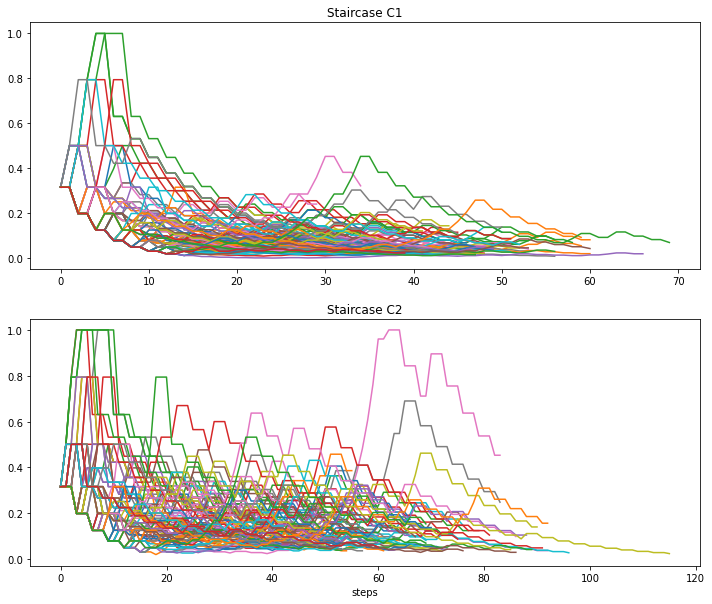

In [7]:
plt.figure(figsize=(12,10))
plt.subplot(211)
for i in range(len(subj_20)):
    plt.plot(range(len(subj_20[i]['part1']['stairs_c1'])), subj_20[i]['part1']['stairs_c1'])
for i in range(len(subj_45)):
    plt.plot(range(len(subj_45[i]['part1']['stairs_c1'])), subj_45[i]['part1']['stairs_c1'])
plt.title('Staircase C1')
plt.subplot(212)
for i in range(len(subj_20)):
    plt.plot(range(len(subj_20[i]['part1']['stairs_c2'])), subj_20[i]['part1']['stairs_c2'])
for i in range(len(subj_45)):
    plt.plot(range(len(subj_45[i]['part1']['stairs_c2'])), subj_45[i]['part1']['stairs_c2'])
plt.title('Staircase C2')
plt.xlabel('steps')
#plt.savefig('s{}_staircase.png'.format(subj_idx))
plt.show()

In [8]:
stairs_coh1_20 = []
stairs_coh2_20 = []
for i in range(len(subj_20)):
    stairs_coh1_20.append(subj_20[i]['part1']['stair_coh1'])
    stairs_coh2_20.append(subj_20[i]['part1']['stair_coh2'])
stairs_coh1_45 = []
stairs_coh2_45 = []
for i in range(len(subj_45)):
    stairs_coh1_45.append(subj_45[i]['part1']['stair_coh1'])
    stairs_coh2_45.append(subj_45[i]['part1']['stair_coh2'])

In [9]:
avg_coh1_20, ste_coh1_20 = compute_mean_sterr_from_vector(stairs_coh1_20)
avg_coh2_20, ste_coh2_20 = compute_mean_sterr_from_vector(stairs_coh2_20)
avg_coh1_45, ste_coh1_45 = compute_mean_sterr_from_vector(stairs_coh1_45)
avg_coh2_45, ste_coh2_45 = compute_mean_sterr_from_vector(stairs_coh2_45)

In [10]:
_ , p_coh1 = st.mannwhitneyu(stairs_coh1_20, stairs_coh1_45)
_ , p_coh2 = st.mannwhitneyu(stairs_coh2_20, stairs_coh2_45)

In [96]:
def plot_barplot_two_means(avg1, ste1, avg2, ste2, p_val = None,
                           name1 = 'A', name2 = 'B',
                           y_lim = None, y_label = None, x_label = None, bar_col = 'grey',
                           shift = 0.2, alpha = 0.05):
    '''
    Plots two barplot from two means and standard errors.
    IN:
      *avg1*, *avg2* - float
        average 1 and average 2
      *ste1*, *ste2* - float
        standard errors 1 & 2
      *p_val* - float
        p value from statistical test comapring two groups
      *name1* = 'A', *name2* = 'B' - str, int
        names to display on x axis
      *y_lim* - list of 2 elements, tuple
        limits of y axis
      *y_label*, *x_label* - str
        y,x label
      *bar_col* = 'grey' - str
        barplto colour
      *shift* - float
        shift between bars
      *alpha* - float
        significance level (only if *p_val* provided)
    OUT:
      plot from matplotlib
    '''
    max_lim = np.max([avg1, avg2])
    plt.bar([0, 1], [avg1, avg2], yerr = [ste1, ste2], color = bar_col)
    plt.xticks([0, 1], [name1, name2])
    if y_lim:
        plt.ylim(y_lim)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    plt.text(0-shift, 0.5*max_lim, '{:.3f} +- {:.3f}'.format(avg1, ste1))
    plt.text(1-shift, 0.5*max_lim, '{:.3f} +- {:.3f}'.format(avg2, ste2))
    if p_val:
        plt.text(0.5-shift, 0.9*max_lim, '{} ({})'.format('*' if p_val < alpha else 'ns',
                                            "p={:.2f}".format(p_val) if p_val >= 0.01 else "p<0.01"))


def plot_paired_value_lines(group1_vals, group2_vals, p_val = None,
                           name1 = 'A', name2 = 'B',
                           y_lim = None, y_label = None, x_label = None,
                           shift = 0.2, alpha = 0.05):
    '''
    Plots two barplot from two means and standard errors.
    IN:
      *group1_vals*, *group2_vals* - list
        values from the first and second groups (need to have the same length)
      *p_val* - float
        p value from statistical test comapring two groups
      *name1* = 'A', *name2* = 'B' - str, int
        names to display on x axis
      *y_lim* - list of 2 elements, tuple
        limits of y axis
      *y_label*, *x_label* - str
        y,x label
      *shift* - float
        shift between bars
      *alpha* - float
        significance level (only if *p_val* provided)
    OUT:
      plot from matplotlib
    '''
    assert len(group1_vals) == len(group2_vals), "length of groups is not the same"
    max_lim = np.max([np.max(group1_vals), np.max(group2_vals)])
    for i in range(len(group1_vals)):
        plt.plot([0, 1], [group1_vals[i], group2_vals[i]], 'o-')
    plt.xticks([0, 1], [name1, name2])
    plt.xlim([-0.5, 1.5])
    if y_lim:
        plt.ylim(y_lim)
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if p_val:
        plt.text(0.5-shift, 0.9*max_lim, '{} ({})'.format('*' if p_val < alpha else 'ns',
                                                                "p={:.2f}".format(p_val) if p_val >= 0.01 else "p<0.01"),
                bbox=dict(boxstyle="round", fc='#ced5df', alpha=0.8))


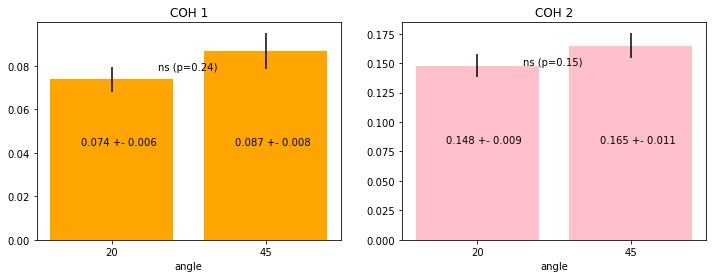

In [97]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plot_barplot_two_means(avg_coh1_20, ste_coh1_20, avg_coh1_45, ste_coh1_45, p_val = p_coh1, name1 = 20, name2 = 45, x_label = 'angle', bar_col = 'orange')
plt.title('COH 1')
plt.subplot(122)
plot_barplot_two_means(avg_coh2_20, ste_coh2_20, avg_coh2_45, ste_coh2_45, p_val = p_coh2, name1 = 20, name2 = 45, x_label = 'angle', bar_col = 'pink')
plt.title('COH 2')
plt.show()

## Group analysis Part 2

### Accuracies

In [85]:
correct_congr_20, correct_incon_20 = [], []
correct_congr_tr_20, correct_incon_tr_20 = [], []
for i in range(len(subj_20)):
    correct_congr_20.append(subj_20[i]['part2']['corrects']['cong_m'])
    correct_incon_20.append(subj_20[i]['part2']['corrects']['incong_m'])
    correct_congr_tr_20.append(subj_20[i]['part2']['corrects']['cong_true_m'])
    correct_incon_tr_20.append(subj_20[i]['part2']['corrects']['incong_true_m'])
correct_congr_45, correct_incon_45 = [], []
correct_congr_tr_45, correct_incon_tr_45 = [], []
for i in range(len(subj_45)):
    correct_congr_45.append(subj_45[i]['part2']['corrects']['cong_m'])
    correct_incon_45.append(subj_45[i]['part2']['corrects']['incong_m'])
    correct_congr_tr_45.append(subj_45[i]['part2']['corrects']['cong_true_m'])
    correct_incon_tr_45.append(subj_45[i]['part2']['corrects']['incong_true_m'])

In [86]:
t_st_con_20, p_con_20 = st.ttest_rel(correct_congr_20, correct_congr_tr_20)
t_st_inc_20, p_inc_20 = st.ttest_rel(correct_incon_20, correct_incon_tr_20)
t_st_con_45, p_con_45 = st.ttest_rel(correct_congr_45, correct_congr_tr_45)
t_st_inc_45, p_inc_45 = st.ttest_rel(correct_incon_45, correct_incon_tr_45)

In [87]:
avg_cong_20, ste_cong_20 = compute_mean_sterr_from_vector(correct_congr_20)
avg_contr_20, ste_contr_20 = compute_mean_sterr_from_vector(correct_congr_tr_20)

avg_inc_20, ste_inc_20 = compute_mean_sterr_from_vector(correct_incon_20)
avg_inctr_20, ste_inctr_20 = compute_mean_sterr_from_vector(correct_incon_tr_20)

avg_cong_45, ste_cong_45 = compute_mean_sterr_from_vector(correct_congr_45)
avg_contr_45, ste_contr_45 = compute_mean_sterr_from_vector(correct_congr_tr_45)

avg_inc_45, ste_inc_45 = compute_mean_sterr_from_vector(correct_incon_45)
avg_inctr_45, ste_inctr_45 = compute_mean_sterr_from_vector(correct_incon_tr_45)

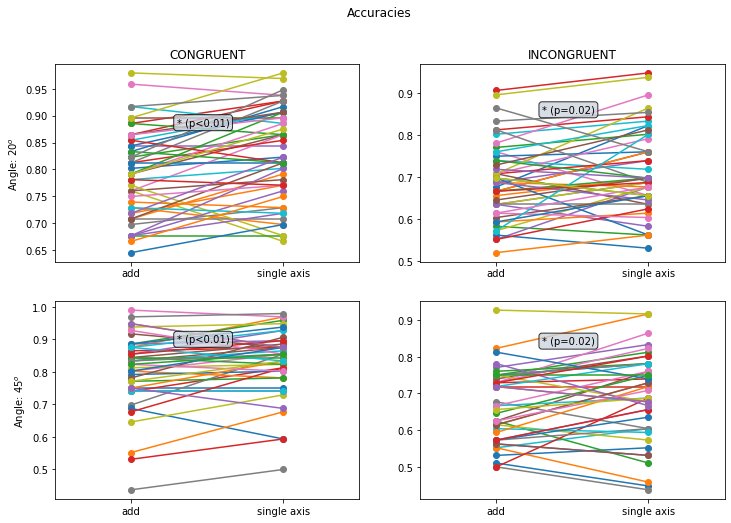

In [98]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_paired_value_lines(correct_congr_20, correct_congr_tr_20, p_val = p_con_20, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 20$^o$')
#plot_barplot_two_means(avg_cong_20, ste_cong_20, avg_contr_20, ste_contr_20, p_val = p_con_20, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 20$^o$', bar_col = '#ffda4f')
plt.title('CONGRUENT')
plt.subplot(222)
plot_paired_value_lines(correct_incon_20, correct_incon_tr_20, p_val = p_inc_20, name1 = 'add', name2 = 'single axis')
#plot_barplot_two_means(avg_inc_20, ste_inc_20, avg_inctr_20, ste_inctr_20, p_val = p_inc_20, name1 = 'add', name2 = 'single axis', bar_col = '#dbdcff')
plt.title('INCONGRUENT')
plt.subplot(223)
plot_paired_value_lines(correct_congr_45, correct_congr_tr_45, p_val = p_con_45, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 45$^o$')
#plot_barplot_two_means(avg_cong_45, ste_cong_45, avg_contr_45, ste_contr_45, p_val = p_con_45, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 45$^o$', bar_col = '#ffda4f')
plt.subplot(224)
plot_paired_value_lines(correct_incon_45, correct_incon_tr_45, p_val = p_inc_45, name1 = 'add', name2 = 'single axis')
#plot_barplot_two_means(avg_inc_45, ste_inc_45, avg_inctr_45, ste_inctr_45, p_val = p_inc_45, name1 = 'add', name2 = 'single axis', bar_col = '#dbdcff')
plt.suptitle('Accuracies')
plt.show()

In [99]:
t_st_con, p_con = st.ttest_ind(correct_congr_20, correct_congr_45)
t_st_inc, p_inc = st.ttest_ind(correct_incon_20, correct_incon_45)
t_st_con_t, p_con_t = st.ttest_ind(correct_congr_tr_20, correct_congr_tr_45)
t_st_inc_t, p_inc_t = st.ttest_ind(correct_incon_tr_20, correct_incon_tr_45)

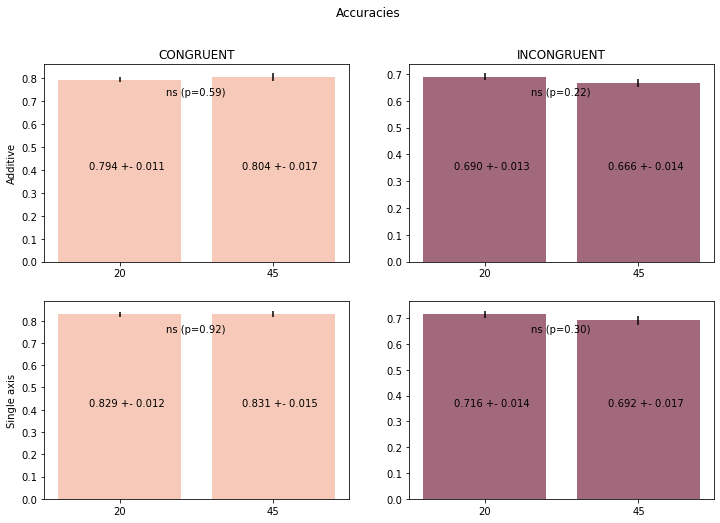

In [100]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_barplot_two_means(avg_cong_20, ste_cong_20, avg_cong_45, ste_cong_45, p_val = p_con, name1 = '20', name2 = '45', y_label = 'Additive', bar_col = '#f6c9b9')
plt.title('CONGRUENT')
plt.subplot(222)
plot_barplot_two_means(avg_inc_20, ste_inc_20, avg_inc_45, ste_inc_45, p_val = p_inc, name1 = '20', name2 = '45', bar_col = '#a2697d')
plt.title('INCONGRUENT')
plt.subplot(223)
plot_barplot_two_means(avg_contr_20, ste_contr_20, avg_contr_45, ste_contr_45, p_val = p_con_t, name1 = '20', name2 = '45', y_label = 'Single axis', bar_col = '#f6c9b9')
plt.subplot(224)
plot_barplot_two_means(avg_inctr_20, ste_inctr_20, avg_inctr_45, ste_inctr_45, p_val = p_inc_t, name1 = '20', name2 = '45', bar_col = '#a2697d')
plt.suptitle('Accuracies')
plt.show()


### RTs

In [101]:
rt_congr_20, rt_incon_20 = [], []
rt_congr_tr_20, rt_incon_tr_20 = [], []
for i in range(len(subj_20)):
    rt_congr_20.append(subj_20[i]['part2']['rts']['cong_m'])
    rt_incon_20.append(subj_20[i]['part2']['rts']['incong_m'])
    rt_congr_tr_20.append(subj_20[i]['part2']['rts']['cong_true_m'])
    rt_incon_tr_20.append(subj_20[i]['part2']['rts']['incong_true_m'])
rt_congr_45, rt_incon_45 = [], []
rt_congr_tr_45, rt_incon_tr_45 = [], []
for i in range(len(subj_45)):
    rt_congr_45.append(subj_45[i]['part2']['rts']['cong_m'])
    rt_incon_45.append(subj_45[i]['part2']['rts']['incong_m'])
    rt_congr_tr_45.append(subj_20[i]['part2']['rts']['cong_true_m'])
    rt_incon_tr_45.append(subj_20[i]['part2']['rts']['incong_true_m'])

In [102]:
t_st_con_20, p_con_20 = st.ttest_rel(rt_congr_20, rt_congr_tr_20)
t_st_inc_20, p_inc_20 = st.ttest_rel(rt_incon_20, rt_incon_tr_20)
t_st_con_45, p_con_45 = st.ttest_rel(rt_congr_45, rt_congr_tr_45)
t_st_inc_45, p_inc_45 = st.ttest_rel(rt_incon_45, rt_incon_tr_45)

In [103]:
avg_cong_20, ste_cong_20 = compute_mean_sterr_from_vector(rt_congr_20)
avg_contr_20, ste_contr_20 = compute_mean_sterr_from_vector(rt_congr_tr_20)

avg_inc_20, ste_inc_20 = compute_mean_sterr_from_vector(rt_incon_20)
avg_inctr_20, ste_inctr_20 = compute_mean_sterr_from_vector(rt_incon_tr_20)

avg_cong_45, ste_cong_45 = compute_mean_sterr_from_vector(rt_congr_45)
avg_contr_45, ste_contr_45 = compute_mean_sterr_from_vector(rt_congr_tr_45)

avg_inc_45, ste_inc_45 = compute_mean_sterr_from_vector(rt_incon_45)
avg_inctr_45, ste_inctr_45 = compute_mean_sterr_from_vector(rt_incon_tr_45)

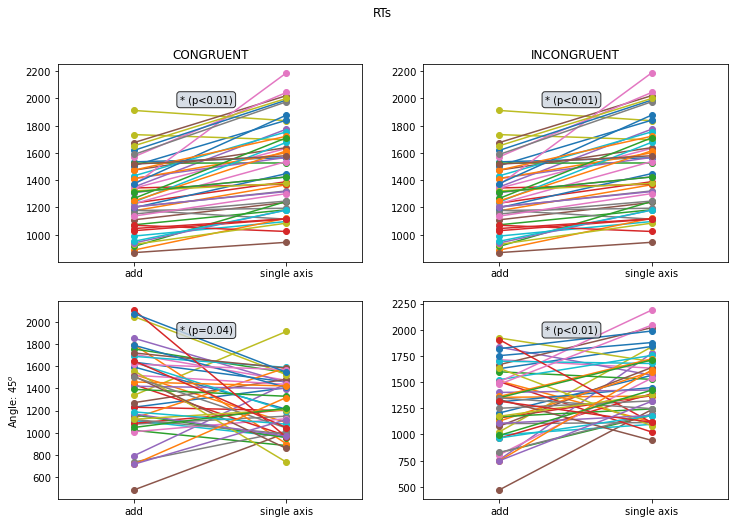

In [104]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_paired_value_lines(rt_incon_20, rt_incon_tr_20, p_val = p_con_20, name1 = 'add', name2 = 'single axis')
#plot_barplot_two_means(avg_cong_20, ste_cong_20, avg_contr_20, ste_contr_20, p_val = p_con_20, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 20$^o$', bar_col = '#ffda4f')
plt.title('CONGRUENT')
plt.subplot(222)
plot_paired_value_lines(rt_incon_20, rt_incon_tr_20, p_val = p_inc_20, name1 = 'add', name2 = 'single axis')
#plot_barplot_two_means(avg_inc_20, ste_inc_20, avg_inctr_20, ste_inctr_20, p_val = p_inc_20, name1 = 'add', name2 = 'single axis', bar_col = '#dbdcff')
plt.title('INCONGRUENT')
plt.subplot(223)
plot_paired_value_lines(rt_congr_45, rt_congr_tr_45, p_val = p_con_45, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 45$^o$')
#plot_barplot_two_means(avg_cong_45, ste_cong_45, avg_contr_45, ste_contr_45, p_val = p_con_45, name1 = 'add', name2 = 'single axis', y_label = 'Angle: 45$^o$', bar_col = '#ffda4f')
plt.subplot(224)
plot_paired_value_lines(rt_incon_45, rt_incon_tr_45, p_val = p_inc_45, name1 = 'add', name2 = 'single axis')
#plot_barplot_two_means(avg_inc_45, ste_inc_45, avg_inctr_45, ste_inctr_45, p_val = p_inc_45, name1 = 'add', name2 = 'single axis', bar_col = '#dbdcff')
plt.suptitle('RTs')
plt.show()

In [105]:
t_st_con, p_con = st.ttest_ind(rt_congr_20, rt_congr_45)
t_st_inc, p_inc = st.ttest_ind(rt_incon_20, rt_incon_45)
t_st_con_t, p_con_t = st.ttest_ind(rt_congr_tr_20, rt_congr_tr_45)
t_st_inc_t, p_inc_t = st.ttest_ind(rt_incon_tr_20, rt_incon_tr_45)

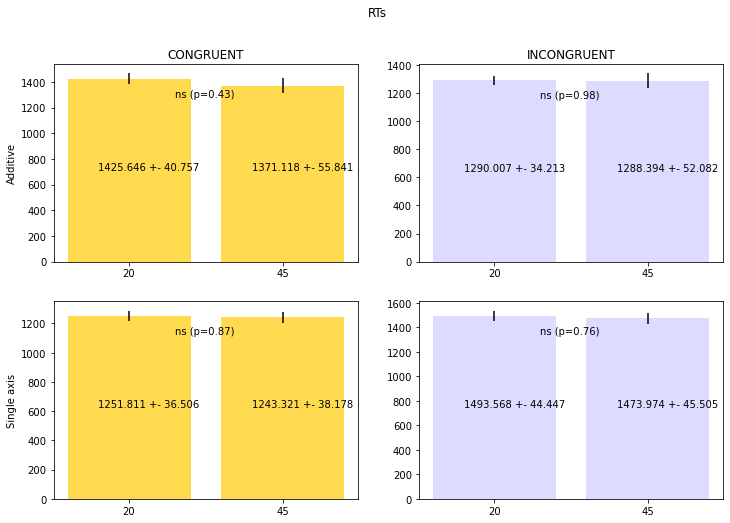

In [106]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plot_barplot_two_means(avg_cong_20, ste_cong_20, avg_cong_45, ste_cong_45, p_val = p_con, name1 = '20', name2 = '45', y_label = 'Additive', bar_col = '#ffda4f')
plt.title('CONGRUENT')
plt.subplot(222)
plot_barplot_two_means(avg_inc_20, ste_inc_20, avg_inc_45, ste_inc_45, p_val = p_inc, name1 = '20', name2 = '45', bar_col = '#dbdcff')
plt.title('INCONGRUENT')
plt.subplot(223)
plot_barplot_two_means(avg_contr_20, ste_contr_20, avg_contr_45, ste_contr_45, p_val = p_con_t, name1 = '20', name2 = '45', y_label = 'Single axis', bar_col = '#ffda4f')
plt.subplot(224)
plot_barplot_two_means(avg_inctr_20, ste_inctr_20, avg_inctr_45, ste_inctr_45, p_val = p_inc_t, name1 = '20', name2 = '45', bar_col = '#dbdcff')
plt.suptitle('RTs')
plt.show()